# Sarcasm Detection on News Headlines - Results & Analysis

This notebook analyses and compares the performance of 5 different models (word2vec, GloVe, fastText, ELMo and DistilBERT). Code used to train these models and provided in other notebooks (their prediction probabilities on the same test set were saved using pickle and loaded here for analysis).

### Setup

###### Import libraries

In [215]:
import pandas as pd
import numpy as np
import pickle

In [216]:
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            accuracy_score, precision_score, recall_score,\
                            matthews_corrcoef, roc_curve, roc_auc_score

###### Load testing data

In [217]:
# Load test dataset
test_data = pd.read_csv("test.csv")
test_data.head()

,is_sarcastic,headline
0,0,"how to make greek easter sweet bread ""tsoureki"""
1,1,theodore roosevelt was a gay man
2,1,man at bar clinging to muted 'king of queens' ...
3,0,the one moment you need to see from last night...
4,0,'hedwig' takes home tony for best revival of a...


In [218]:
# True labels
target = test_data['is_sarcastic']
target.head()

0    0
1    1
2    1
3    0
4    0
Name: is_sarcastic, dtype: int64

###### Load prediction probabilities from each model

In [320]:
# Load DistilBERT Probabilities
distilbert_probabilities = pickle.load(open("prediction_probabilities_distilbert_3.pkl", 'rb'))
distilbert_pred_prob_1 = distilbert_probabilities[:,1].numpy()

# Get binary classification from prediction probabilities
distilbert_predictions = np.argmax(distilbert_probabilities, axis=1)

In [220]:
# Load word2vec probabilities
word2vec_pred_prob_1 = pickle.load(open("word2vec_probs_for_1.pkl", 'rb'))
word2vec_pred_prob_1 = word2vec_pred_prob_1.flatten()

In [221]:
# Load GloVe probabilities
glove_pred_prob_1 = pickle.load(open("glove_probs_for_1.pkl", 'rb'))
glove_pred_prob_1 = glove_pred_prob_1.flatten()

In [222]:
# Load ELMo probabilities
elmo_pred_prob_1 = pickle.load(open("elmo_probs_for_1.pkl", 'rb'))
elmo_pred_prob_1 = elmo_pred_prob_1.flatten()

In [223]:
# Load FastText probabilities
fasttext_pred_prob_1 = np.array(pickle.load(open("fasttext_probs_for_1.pkl", 'rb')))

In [224]:
models = [
  {
    "name": "DistilBERT",
    "pred_prob_1": distilbert_pred_prob_1
  },
  {
    "name": "word2vec",
    "pred_prob_1": word2vec_pred_prob_1
  },
  {
    "name": "GloVe",
    "pred_prob_1": glove_pred_prob_1
  },
  {
    "name": "ELMo",
    "pred_prob_1": elmo_pred_prob_1
  },
  {
    "name": "fastText",
    "pred_prob_1": fasttext_pred_prob_1
  }
]

### Performance statistics per model

In [225]:
performance_stats = []
for model in models:
  # Get the binary classification prediction from the prediction probability for 1 (headline is sarcastic)
  predictions = (np.array(model["pred_prob_1"]) > 0.5).astype(int)

  # get performance metrics
  performance_stats.append(
        {
          "Model": model["name"],
          "Accuracy": accuracy_score(target, predictions),
          "Precision": precision_score(target, predictions),
          "Recall": recall_score(target, predictions),
          "MCC": matthews_corrcoef(target, predictions),
          "Confusion Matrix": confusion_matrix(target, predictions),
          "ROC Curve": roc_curve(target, model["pred_prob_1"]),
          "ROC AUC Score": roc_auc_score(target, model["pred_prob_1"])
        })

In [226]:
performance_df = pd.DataFrame(performance_stats)
pd.set_option('precision', 2)
performance_df.iloc[:,:5]

,Model,Accuracy,Precision,Recall,MCC
0,DistilBERT,0.92,0.93,0.90,0.84
1,word2vec,0.88,0.86,0.88,0.75
2,GloVe,0.82,0.83,0.79,0.64
3,ELMo,0.79,0.79,0.76,0.58
4,fastText,0.81,0.82,0.78,0.62


###### Accuracy, precision, and recall

Text(0.5, 1.0, 'Model Performance')

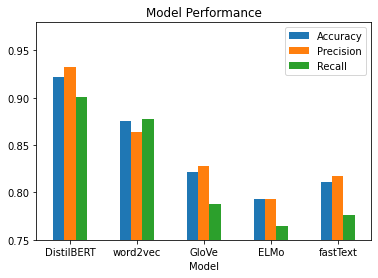

In [227]:
ax = performance_df.plot.bar(x='Model', y=['Accuracy', 'Precision', 'Recall'], rot=0)
ax.set_ybound(lower=0.75)
ax.set_title("Model Performance")

###### Matthews' Correlation Coefficient (MCC)

Text(0.5, 1.0, "Matthews' Correlation Coefficients")

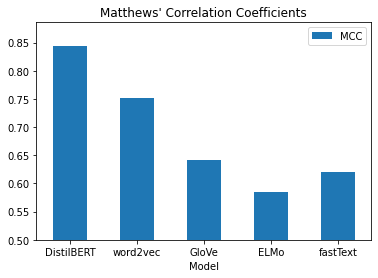

In [228]:
ax = performance_df.plot.bar(x='Model', y='MCC', rot=0)
ax.set_ybound(lower=0.5)
ax.set_title("Matthews' Correlation Coefficients")

###### Confusion Matrices

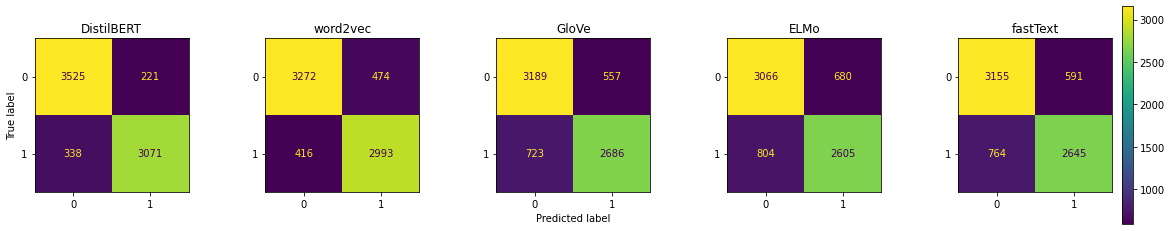

In [229]:
# Plot confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, model in enumerate(performance_stats):
  disp = ConfusionMatrixDisplay(confusion_matrix=model["Confusion Matrix"])
  disp.plot(ax=axes[i])
  disp.ax_.set_title(model["Model"])
  if i != len(performance_stats) - 1:
    disp.im_.colorbar.remove()
  if i != int(len(performance_stats) / 2):
    disp.ax_.set_xlabel('')
  if i != 0:
    disp.ax_.set_ylabel('')

###### ROC Curves

Text(0.5, 1.0, 'ROC Curves')

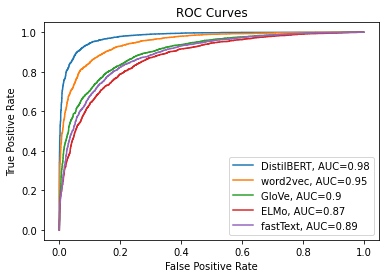

In [230]:
plt.figure(0).clf()

# Plot ROC curves
for i, model in enumerate(performance_stats):
  fpr, tpr, _ = model["ROC Curve"]
  auc = model["ROC AUC Score"]
  plt.plot(fpr,tpr,label=f"{model['Model']}, AUC={round(auc, 2)}")

plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curves")

### Ensemble Modelling

###### Model weights

We will use the Matthews Correlation Coefficient to weight each model in the ensemble.

In [313]:
# Choose an offset (less than minimum MCC = 0.58)
# higher offset will give larger (more extreme) weighting to better models
offset = 0.5

#### Took out DistilBERT

# get model weight based on model's MCC value
def get_model_weight(mcc_val):
  return (mcc_val - offset)/sum(performance_df.loc[1:,'MCC'] - offset)

performance_df['Weight'] = performance_df.apply(lambda row: get_model_weight(row['MCC']), axis=1)

# Check that sum of weights is equal to 1
print(f"Sum of weights = {sum(performance_df.loc[1:,'Weight'])}")

performance_df.loc[1:,['Model', 'MCC', 'Weight']]

Sum of weights = 1.0


,Model,MCC,Weight
1,word2vec,0.75,0.42
2,GloVe,0.64,0.24
3,ELMo,0.58,0.14
4,fastText,0.62,0.20


###### Compute ensemble prediction probabilties

In [314]:
ensemble_pred_probs = np.zeros_like(distilbert_pred_prob_1, dtype='float64')

#### Does not include DistilBERT
for model in models[1:]:
  weight = performance_df.loc[performance_df['Model'] == model['name'], 'Weight'].iloc[0]
  ensemble_pred_probs = np.add(ensemble_pred_probs, weight * model['pred_prob_1'])

In [315]:
# Get the binary classification prediction from the prediction probability for 1 (headline is sarcastic)
ensemble_predictions = (ensemble_pred_probs > 0.5).astype(int)

In [316]:
print(accuracy_score(target, ensemble_predictions))
print(precision_score(target, ensemble_predictions))
print(recall_score(target, ensemble_predictions))

print(matthews_corrcoef(target, ensemble_predictions))

0.8849755415793151
0.8816410861865407
0.8762100322675271
0.769389024963532
